In [1]:
import os
import random
import time

import numpy as np
import pandas as pd
import scipy as sc
from scipy.io import wavfile
from scipy import signal
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import Compose

import tensorboardX
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
class AudioFrameDataset(Dataset):
    '''Train only'''

    def __init__(self, path_to_data, path_to_split, phase, transform=None, seed=14): 
        self.path_to_data = path_to_data
        voice_set_labels = pd.read_table(path_to_split, sep=' ', names=['path', 'phase'])
        voice_set_labels.replace({'_000': '/0', '.wav$': ''}, inplace=True, regex=True)
        
        # if-else conditions are bullshit there's no need for them because 
        # we need to use another file with predefined pairs for evaluation purposes
        if phase == 1:
            mask = (voice_set_labels.phase == 1) | (voice_set_labels.phase == 3)
            dataset = voice_set_labels[mask].reset_index(drop=True)

        else:
            mask = voice_set_labels['phase'] == phase
            dataset = voice_set_labels[mask].reset_index(drop=True)
            
        self.dataset = dataset['path']
        self.transform = transform
        self.seed = np.random.RandomState(seed)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        t0 = time.time()
        
        ### VISUAL INPUT
        video_path = os.path.join(self.path_to_data, 'video', self.dataset[idx] + '.txt')
        frames = pd.read_table(video_path, skiprows=6, usecols=['FRAME '])
        out_f.write('After pd.read_table: +{:.2f}\n'.format(time.time() - t0))
        earliest = frames['FRAME '].iloc[0]
        latest = frames['FRAME '].iloc[-1]
        frame_list = np.arange(earliest, latest+1)
        mask = np.where(frame_list % 25 == 0)
        out_f.write('After np.where: +{:.2f}\n'.format(time.time() - t0))
        # only 20 per each face-track (see the asterics on the project page)
        # frames_sec = frame_list[mask]
        frames_sec = frame_list[mask][:20]
        selected_frame = self.seed.choice(frames_sec)
        selected_frame_filename = '{0:07d}.jpg'.format(selected_frame)
        selected_frame_path = os.path.join(self.path_to_data, 'video', 
                                           self.dataset[idx][:-5] + selected_frame_filename)
#         out_f.write(selected_frame_path + '\n')
        out_f.write('Before reading image with opencv: +{:.2f}\n'.format(time.time() - t0))
        frame = cv2.cvtColor(cv2.imread(selected_frame_path), cv2.COLOR_BGR2RGB)
        out_f.write('After reading image with opencv: +{:.2f}\n'.format(time.time() - t0))
        frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_CUBIC)
        out_f.write('After resizing the image: +{:.2f}\n'.format(time.time() - t0))
        out_f.write('Total after image preparation: +{:.2f}\n'.format(time.time() - t0))
        
        ### AUDIO INPUT
        segment_len = 3
        # not 1024 as reported in the referenced paper [35] 
        # because it gives 513xN but not 512xN
        FFT_len = 1022
        window = 'hamming'
        audio_path = os.path.join(self.path_to_data, 'audio', self.dataset[idx] + '.wav')
        out_f.write('After path is chosen: +{:.2f}\n'.format(time.time() - t0))
#         out_f.write(audio_path + '\n')
        sample_rate, samples = wavfile.read(audio_path)
        out_f.write('After wavefile has been read: +{:.2f}\n'.format(time.time() - t0))
        window_width = int(sample_rate * 0.025)
        overlap = int(sample_rate * (0.025 - 0.010))
        start = len(samples) - segment_len * sample_rate
        end = start + segment_len * sample_rate
        audio_segment = samples[start:end]
        # Note, it produces 512x298 and I don't know why there is some subtle
        # differences. However, since the model averages second axis it doesn't
        # matter from the computational POV.
        out_f.write('After cropping the sample: +{:.2f}\n'.format(time.time() - t0))
        _, _, spectrogram = signal.spectrogram(audio_segment, sample_rate, 
                                               window=window, nfft=FFT_len, 
                                               nperseg=window_width, noverlap=overlap, 
                                               mode='magnitude')
        out_f.write('After spectogram calculation: +{:.2f}\n'.format(time.time() - t0))
#         log_spectogram = np.log(spectrogram)
        log_spectogram = spectrogram.copy()
        out_f.write('After spectrogram.copy(): +{:.2f}\n'.format(time.time() - t0))
        assert sample_rate == 16000
        assert len(samples) >= sample_rate * segment_len
        
#         out_f.write(np.array_str(frame) + '\n')
#         out_f.write(np.array_str(log_spectogram) + '\n')
        
        if self.transform:
            frame = frame.astype(np.float32)
            log_spectogram = log_spectogram.astype(np.float32)
            frame, log_spectogram = self.transform((frame, log_spectogram))
        out_f.write('After transforms(): +{:.2f}\n'.format(time.time() - t0))
        out_f.write('Total time elapsed for one index: +{:.2f}\n\n'.format(time.time() - t0))
        
        return frame, log_spectogram

In [3]:
class Normalize(object):
    """Normalizes both face (mean) and voice spectogram (mean-varience)"""
    
    def __call__(self, sample):
        frame, log_spectogram = sample

        ## FACE (H, W, C)
        # mean normalization for every image (not batch)
        mu = frame.mean(axis=(0, 1))
        frame = frame - mu
        
        ## VOICE (Freq, Time)
        # mean-variance normalization for every spectogram (not batch)
        mu = log_spectogram.mean(axis=1).reshape(512, 1)
        sigma = log_spectogram.std(axis=1).reshape(512, 1)
        log_spectogram = (log_spectogram - mu) / sigma

        return frame, log_spectogram

class RandomHorizontalFlip(object):
    '''Horizontally flip the given Image ndarray randomly with a given probability.'''
    
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        frame, log_spectogram = sample

        if random.random() < self.p:
            return cv2.flip(frame, 1), log_spectogram
        
        return frame, log_spectogram

class ColorJittering(object):
    '''Given Image ndarray performs brightness and 
    saturation jittering. It is not mentioned in the paper but I guess 
    the authors used MatConvNet but do not mention any specific augmentation
    parameters. So, I made my wind guess regarding the parameters and implemented
    augmentation in the following fashion as in there:
    http://www.vlfeat.org/matconvnet/mfiles/vl_imreadjpeg/
    and the Section 3.5 of the manual
    http://www.vlfeat.org/matconvnet/matconvnet-manual.pdf'''
    
    def __init__(self, brightness=[255/25.5, 255/25.5, 255/25.5], saturation=0.5):
        # brightness
        self.B = np.array(brightness, dtype=np.float32)
        # saturation
        self.S = saturation
    
    def __call__(self, sample):
        frame, log_spectogram = sample
        
        # brightness
        # gives an error w/o float32 -- normal() returns float64
        w = np.float32(np.random.normal(size=3))
        b = self.B * w
        frame = np.clip(frame + b, 0, 255)
        
        # saturation
        sigma = np.random.uniform(1-self.S, 1+self.S)
        frame = sigma * frame + (1-sigma) / 3 * frame.sum(axis=2, keepdims=True)
        frame = np.clip(frame, 0, 255)
        
        return frame, log_spectogram
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        frame, log_spectogram = sample
        F, T = log_spectogram.shape

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        frame = frame.transpose((2, 0, 1))
        
        # now log_specs are of size (Freq, Time) 2D but has to be 3D
        log_spectogram = log_spectogram.reshape(1, F, T)

        return torch.from_numpy(frame), torch.from_numpy(log_spectogram)

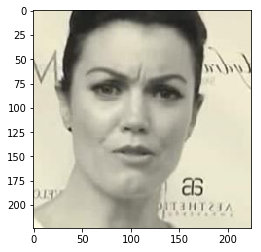

In [4]:
plt.figure()
img = cv2.imread('/home/hdd/data/voxceleb1/video/Bellamy_Young/vZY1f9oeIbo/0001350.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = cv2.flip(img, 1)
plt.imshow(img)
plt.show()

In [5]:
## TRY TO ADD DROPOUT

class FaceSubnet(nn.Module):

    def __init__(self, seed=13):
        super(FaceSubnet, self).__init__()
#         torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        
        self.fc6 = nn.Linear(in_features=256 * 7 * 7, out_features=4096)
        self.fc7 = nn.Linear(in_features=4096, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=256)
        
        self.mpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        B, C, H, W = x.size()
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.mpool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.mpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        
        return F.normalize(x)

## TRY TO REMOVE DROPOUT

class VoiceSubnet(nn.Module):

    def __init__(self, seed=13):
        super(VoiceSubnet, self).__init__()
#         torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=7, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        
        self.bn6 = nn.BatchNorm2d(num_features=4096)
        
        self.fc7 = nn.Linear(in_features=4096, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=256)
        
        self.relu = nn.ReLU()
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool5 = nn.MaxPool2d(kernel_size=(5, 3), stride=(3, 2))
        
        # Conv2d with weights of size (H, 1) is identical to FC with H weights
        self.fc6 = nn.Conv2d(in_channels=256, out_channels=4096, kernel_size=(9, 1))
        
    def forward(self, x):
        B, C, H, W = x.size()

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.mpool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.mpool5(x)

        B, C, H, W = x.size()
        self.apool6 = nn.AvgPool2d(kernel_size=(1, W))

        x = self.relu(self.bn6(self.fc6(x)))
        x = self.apool6(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        
        return F.normalize(x)
    
class CurriculumMining(nn.Module):

    def __init__(self):
        super(CurriculumMining, self).__init__()
        
    def forward(self, positive_pairs, tau):
        faces, voices = positive_pairs
        B, D = faces.size()
        # calc dist 
        # (X - Y) ^ 2 = X^2 + Y^2 - 2XY
        x = (faces**2).sum(dim=1).view(-1, 1) + (voices**2).sum(dim=1) - 2*faces.matmul(voices.t())
        dists = x.sqrt()
        
        sorted_dist, sorted_idx = torch.sort(dists, dim=1, descending=True)
        Dnj = sorted_dist - dists.diag().view(-1, 1)
        idx_threshold = round(tau * (B-1))
        
        # tricky part
        mask = torch.ones_like(sorted_dist)
        mask[:, idx_threshold+1:] = 0
        mask[Dnj <= 0] = 0
        idx_of_sorted_idx = ((mask).sum(dim=1) - 1).abs().long()
        neg_samples_idx = torch.gather(sorted_idx, dim=1, index=idx_of_sorted_idx.view(B, 1))
        neg_samples_idx = neg_samples_idx.view(B)
        negative_voices = voices[neg_samples_idx]
        
        return (faces, negative_voices)

class ContrastiveLoss(nn.Module):

    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        
    def forward(self, positive_pairs, negative_pairs, margin):
        ## POSITIVE PART
        faces, voices = positive_pairs
#         dists_pos = ((faces - voices) ** 2).sum(dim=1).sqrt()
#         pos_part = dists_pos ** 2
        pos_part = ((faces - voices) ** 2).sum(dim=1)
    
        ## NEGATIVE PART
        faces, voices = negative_pairs
        dists_neg = ((faces - voices) ** 2).sum(dim=1).sqrt()
        neg_part = (margin - dists_neg).clamp(0) ** 2
        
        loss4pair = torch.cat([pos_part, neg_part])
        
        ## CALCULATE LOSS
        B, D = faces.size()
        batch_loss = loss4pair.sum() / (2 * B)
    
        return batch_loss

class LearnablePinsNet(nn.Module):

    def __init__(self):
        super(LearnablePinsNet, self).__init__()
        self.face_subnet = FaceSubnet()
        self.voice_subnet = VoiceSubnet()
        self.curr_mining = CurriculumMining()
        
    def forward(self, frames, log_specs, tau=None):
        emb_f = self.face_subnet(frames)
        emb_v = self.voice_subnet(log_specs)
        
        if self.training:
            positive_pairs = (emb_f, emb_v)
            negative_pairs = self.curr_mining(positive_pairs, tau)

            return positive_pairs, negative_pairs
        
        else:
            return (emb_f, emb_v)

In [6]:
class TauScheduler(object):
    '''
    ## TODO: new doc str
    [trash]:
    "found that it was effective to increase \tau by 10 percent 
    every two epochs, starting from 30% up until 80%, and keeping 
    it constant thereafter"
    --- So, it is increasing up to 10th epoch where becomes 0.8
    '''
    
    def __init__(self, lowest, highest):
        self.current = int(lowest * 100)
        self.highest = int(highest * 100)
        self.epoch_num = 0

    def step(self):
            
        if self.epoch_num % 2 == 0 and self.epoch_num > 0:
#                 self.current += 10
            self.current = int(self.current + self.current * 0.1)
        
        if self.current > self.highest:
            self.current = 80
    
        self.epoch_num += 1
        
    def get_tau(self):
        return self.current / 100

In [7]:
# tau_scheduler = TauScheduler(0.3, 0.8)
# for i in range(50):
#     tau_scheduler.step()
#     print(i, tau_scheduler.get_tau())

In [8]:
LOG_PATH = '/home/hdd/logs/LearnablePINs8/'
TXT_LOG_PATH = os.path.join(LOG_PATH, 'debug_log.txt')
DATA_PATH = '/home/hdd/data/voxceleb1/'
USE_FILTERED = True

if USE_FILTERED:
    SPLIT_PATH = os.path.join(DATA_PATH, 'Splits/filtered_voice_set_labels.txt')

else:
    SPLIT_PATH = os.path.join(DATA_PATH, 'Splits/voice_set_labels.txt')

FACE_SUBNET_SNAPSHOT_PATH = os.path.join(LOG_PATH, 'face_subnet_snapshot.txt')
VOICE_SUBNET_SNAPSHOT_PATH = os.path.join(LOG_PATH, 'voice_subnet_snapshot.txt')
PHASE = 1
DEVICES = [0, 1, 2]
B = 50 * len(DEVICES)
# https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/5
NUM_WORKERS = 4 * len(DEVICES)
MARGIN = 0.6

In [9]:
out_f = open(TXT_LOG_PATH, 'w')
TBoard = tensorboardX.SummaryWriter(log_dir=LOG_PATH)

try:
    transform = Compose([
        Normalize(),
        RandomHorizontalFlip(),
        ColorJittering(),
        ToTensor(),
    ])

    train = AudioFrameDataset(DATA_PATH, SPLIT_PATH, phase=PHASE, transform=transform)
    trainloader = torch.utils.data.DataLoader(train, batch_size=B, num_workers=NUM_WORKERS)

    net = LearnablePinsNet()

    criterion = ContrastiveLoss()
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10 ** (-3/25))
    tau_scheduler = TauScheduler(lowest=0.3, highest=0.8)

    device = "cuda"
    torch.cuda.set_device(DEVICES[0])
    net.to(device);
    net = nn.DataParallel(net, DEVICES)

    for epoch_num in range(50):
        net.train()
        lr_scheduler.step()
        tau_scheduler.step()

        for iter_num, (frames, log_specs) in tqdm(enumerate(trainloader)):
            step_num = epoch_num * len(trainloader) + iter_num
            out_f.write('{}-{}\n'.format(epoch_num, iter_num))
            t0 = time.time()

            # transfer inputs to a device
            frames, log_specs = frames.cuda(async=True), log_specs.cuda(async=True)
            frames, log_specs = torch.autograd.Variable(frames), torch.autograd.Variable(log_specs)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            positive_pairs, negative_pairs = net(frames, log_specs, tau=tau_scheduler.get_tau())
#             TBoard.add_scalar('Timing/InferenceTime', time.time() - t0, step_num)
            loss = criterion(positive_pairs, negative_pairs, margin=MARGIN)

            loss.backward()
            optimizer.step()

            TBoard.add_scalar('Train/Loss', loss.item(), step_num)
            TBoard.add_scalar('Train/lr', lr_scheduler.get_lr()[0], step_num)
            TBoard.add_scalar('Train/tau', tau_scheduler.get_tau(), step_num)
            TBoard.add_scalar('emb_mean/face', positive_pairs[0].mean(), step_num)
            TBoard.add_scalar('emb_mean/voice', positive_pairs[1].mean(), step_num)

            if hasattr(net, 'module'):
                TBoard.add_scalar('weights/voice_conv1', net.module.voice_subnet.conv1.weight.mean(), step_num)
                TBoard.add_scalar('weights/face_conv1', net.module.face_subnet.conv1.weight.mean(), step_num)
                TBoard.add_scalar('weights/voice_conv5', net.module.voice_subnet.conv5.weight.mean(), step_num)
                TBoard.add_scalar('weights/face_conv5', net.module.face_subnet.conv5.weight.mean(), step_num)

            else:
                TBoard.add_scalar('weights/voice_conv1', net.voice_subnet.conv1.weight.mean(), step_num)
                TBoard.add_scalar('weights/face_conv1', net.face_subnet.conv1.weight.mean(), step_num)
                TBoard.add_scalar('weights/voice_conv5', net.voice_subnet.conv5.weight.mean(), step_num)
                TBoard.add_scalar('weights/face_conv5', net.face_subnet.conv5.weight.mean(), step_num)

#             TBoard.add_scalar('raw_input/face_mean', frames.mean(), step_num)
#             TBoard.add_scalar('raw_input/voice_mean', log_specs.mean(), step_num)
#             TBoard.add_scalar('Timing/IterTime', time.time() - t0, step_num)
            
            
except KeyboardInterrupt:
    out_f.close()
    TBoard.close()
    print('TBoard and log file has been closed!')
    
out_f.close()
TBoard.close()

150it [02:22,  1.45it/s]Process Process-1:


TBoard and log file has been closed!


Traceback (most recent call last):
Process Process-3:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/vladimir/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/vladimir/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-2-e3215a3d144e>", line 47, in __getitem__
    frame = cv2.cvtColor(cv2.imread(selected_frame_path), cv2.COLOR_

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vladimir/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/vladimir/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-2-e3215a3d144e>", line 62, in __getitem__
    sample_rate, samples = wavfile.read(audio_path)
  File "/home/vladimir/venv/lib/python3.5/site-packages/scipy/io/wavfile.py", line 264, in read
    is_big_endian, mmap)
  File "/home/vladimir/venv/lib/python3.5/site-packages/scipy/io/wavfile.py", line 129, in _read_data_chunk
    data = numpy.frombuffer(fid.read(size), dtype=dtype)
KeyboardInterrupt
Process Process-7:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py",

In [10]:
torch.cuda.empty_cache()

Traceback (most recent call last):
  File "/home/vladimir/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-18bf08814031>", line 1, in <module>
    torch.cuda.empty_cache()
  File "/home/vladimir/venv/lib/python3.5/site-packages/torch/cuda/__init__.py", line 365, in empty_cache
    torch._C._cuda_emptyCache()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vladimir/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2016, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vladimir/venv/lib/python3.5/site-packages/IPython/core/ultratb.py", line 1095, in get_rec

KeyboardInterrupt: 

In [ ]:
torch.save(net.module.face_subnet.state_dict(), FACE_SUBNET_SNAPSHOT_PATH)
torch.save(net.module.voice_subnet.state_dict(), VOICE_SUBNET_SNAPSHOT_PATH)